# RNN - Insurance

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
data = pd.read_excel('../raw_data/daily_data_clean.xlsx', engine='openpyxl')

In [3]:
data = data.drop(columns=['Unnamed: 0', 'date_issue'])

In [4]:
data

,total_amount_claims
0,168
1,346
2,16169
3,28529
4,64135
...,...
915,350720
916,293427
917,333658
918,139824


In [5]:
print("min: ",data['total_amount_claims'].min())
print("max: ",data['total_amount_claims'].max())

min:  31
max:  713904


In [4]:
# data_sept_18 = data[data['date_issue'] < '2018-10-01']
# data_sept_18.max()

date_issue             2018-09-30 00:00:00
total_amount_claims                 686066
dtype: object

In [5]:
# data_oct_18 = data[(data['date_issue'] < '2018-11-01') & (data['date_issue']>'2018-10-01')]
# data_oct_18.max()

date_issue             2018-10-31 00:00:00
total_amount_claims                 334808
dtype: object

### Normalization, ver 1000

In [6]:
data['total_amount_claims'] = data['total_amount_claims']/1000

In [7]:
data.head()

,total_amount_claims
0,0.168
1,0.346
2,16.169
3,28.529
4,64.135


In [8]:
data.shape

(920, 1)

### Split data

In [9]:
len_ = int(0.8*data.shape[0])

data_train = data[:len_]
data_test = data[len_:]

print(data_train.shape)
print(data_test.shape)

### Sequences

In [11]:
def subsample_sequence(data, length):
    
    last_possible = data.shape[0] - length
    
    random_start = np.random.randint(0, last_possible)
    data_sample = data[random_start: random_start+length]
    
    return data_sample

In [12]:
data_subsample = subsample_sequence(data, 10)
data_subsample

,total_amount_claims
565,47.263
566,49.227
567,17.043
568,9.716
569,52.475
570,86.622
571,69.206
572,83.963
573,125.587
574,87.723


In [36]:
def fillna(X, data_mean):
    # Replace with NaN of the other hours. 
    na = X.mean()
    
    # If the other hours are also nans, then replace with mean value of the dataframe
    na.fillna(data_mean)
    return na

def split_subsample_sequence(data, length, data_mean=None):
    # Little trick to improve the time
    if data_mean is None:
        data_mean = data.mean()
              
    data_subsample = subsample_sequence(data, length)
    y_sample = data_subsample.iloc[data_subsample.shape[0]-1]['total_amount_claims']
    
    if y_sample != y_sample: # A value is not equal to itself only for NaN. So it will be True if y_sample is nan
        X_sample, y_sample = split_subsample_sequence(data, length, data_mean)
        return np.array(X_sample), np.array(y_sample)
    
    X_sample = data_subsample[0:data_subsample.shape[0]-1]
    X_sample = X_sample.fillna(fillna(X_sample, data_mean))
    X_sample = X_sample.values
    
    return np.array(X_sample), np.array(y_sample)

In [37]:
def get_X_y(data, number_of_sequences, length):
    X, y = [], []

    for i in range(number_of_sequences):
        xi, yi = split_subsample_sequence(data, length)
        X.append(xi)
        y.append(yi)
        
    X = np.array(X)
    y = np.array(y)
        
    return X, y

In [38]:
X_train, y_train = get_X_y(data_train, 1000, 50)
X_test, y_test = get_X_y(data_test, 200, 50)

In [39]:
X_train

array([[[ 65.851],
        [ 39.15 ],
        [ 15.377],
        ...,
        [ 61.095],
        [ 93.96 ],
        [ 86.208]],

       [[172.687],
        [124.756],
        [ 24.965],
        ...,
        [ 59.214],
        [ 57.509],
        [ 50.379]],

       [[147.372],
        [ 74.947],
        [ 14.935],
        ...,
        [ 45.19 ],
        [  3.619],
        [  1.505]],

       ...,

       [[ 17.704],
        [ 42.108],
        [107.293],
        ...,
        [ 94.928],
        [133.414],
        [ 86.393]],

       [[ 82.437],
        [ 34.906],
        [ 18.88 ],
        ...,
        [149.646],
        [148.787],
        [ 97.595]],

       [[ 31.064],
        [112.635],
        [ 41.858],
        ...,
        [  4.358],
        [ 14.683],
        [ 22.488]]])

In [ ]:
# !pip install tensorflow

In [40]:
print(f'X train size:{X_train.shape}')
print(f'X test size:{X_test.shape}')
print(f'y train size:{y_train.shape}')
print(f'y test size:{y_test.shape}')

X train size:(1000, 49, 1)
X test size:(200, 49, 1)
y train size:(1000,)
y test size:(200,)


In [41]:
from tensorflow.keras import models
from tensorflow.keras import layers

model = models.Sequential()

model.add(layers.LSTM(20, activation='tanh'))
model.add(layers.Dense(5, activation='relu'))
model.add(layers.Dense(1, activation='linear'))

In [42]:
model.compile(loss='mse', 
              optimizer='rmsprop', 
              metrics=['mae', 'mape'])

In [43]:
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3, restore_best_weights=True)

history = model.fit(X_train, y_train,
            validation_split=0.2,
            epochs=100, 
            batch_size=16,
            callbacks=[es])

Epoch 1/100
50/50 [==============================] - 3s 29ms/step - loss: 11984.8742 - mae: 79.0055 - mape: 97.8619 - val_loss: 17671.1543 - val_mae: 90.7490 - val_mape: 98.7666
Epoch 2/100
50/50 [==============================] - 1s 18ms/step - loss: 13504.9467 - mae: 78.8340 - mape: 96.5785 - val_loss: 17318.7363 - val_mae: 88.9147 - val_mape: 102.8765
Epoch 3/100
50/50 [==============================] - 1s 18ms/step - loss: 13015.1621 - mae: 76.7944 - mape: 100.4539 - val_loss: 16934.8770 - val_mae: 86.8416 - val_mape: 109.3037
Epoch 4/100
50/50 [==============================] - 1s 17ms/step - loss: 13244.1809 - mae: 75.9196 - mape: 109.6001 - val_loss: 16406.5059 - val_mae: 84.0895 - val_mape: 118.5443
Epoch 5/100
50/50 [==============================] - 1s 18ms/step - loss: 12621.5463 - mae: 76.4944 - mape: 133.6109 - val_loss: 15839.5283 - val_mae: 81.2003 - val_mape: 128.7427
Epoch 6/100
50/50 [==============================] - 1s 17ms/step - loss: 12084.4623 - mae: 71.5788 - m

In [44]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 20)                1760      
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 105       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 6         
Total params: 1,871
Trainable params: 1,871
Non-trainable params: 0
_________________________________________________________________


In [45]:
model_eval = model.evaluate(X_test, y_test, verbose=0)
print(f'Model Mean Absolute Error {model_eval[1]:.4f}')
print(f'Model Mean Absolute Porcentual Error {model_eval[2]:.4f}')

Model Mean Absolute Error 127.9644
Model Mean Absolute Porcentual Error 50.5294


In [ ]:
# tf.keras.losses.MAPE(
#     y_true, y_pred
# )

#### Prediction

In [46]:
predict = model.predict(X_test)

In [47]:
predict

array([[111.233025],
       [109.67674 ],
       [110.09986 ],
       [111.186165],
       [110.93913 ],
       [111.11185 ],
       [110.770065],
       [111.18508 ],
       [ 78.76856 ],
       [111.133514],
       [110.90806 ],
       [110.09986 ],
       [ 89.53665 ],
       [111.24046 ],
       [106.41367 ],
       [ 79.253426],
       [111.22293 ],
       [111.186455],
       [100.93527 ],
       [111.21255 ],
       [111.24046 ],
       [110.64237 ],
       [110.09986 ],
       [111.1649  ],
       [111.21607 ],
       [111.04459 ],
       [111.19356 ],
       [111.09083 ],
       [110.8897  ],
       [110.86381 ],
       [111.22624 ],
       [106.75597 ],
       [111.239716],
       [111.229904],
       [ 97.37508 ],
       [110.33071 ],
       [ 95.95842 ],
       [109.839325],
       [ 98.79572 ],
       [111.13695 ],
       [109.7929  ],
       [103.069695],
       [109.7929  ],
       [111.08674 ],
       [ 78.76856 ],
       [106.193535],
       [111.1893  ],
       [102.2

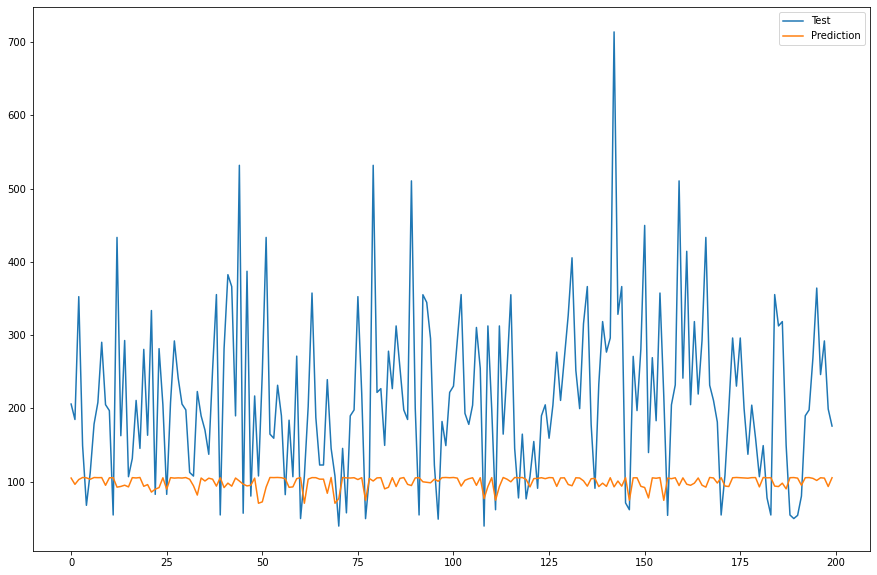

In [35]:
plt.figure(figsize=(15,10))
plt.plot(y_test,label = 'Test')
plt.plot(predict, label = 'Prediction')
plt.legend(loc='best')
plt.show()